In [16]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
#https://ilmonteux.github.io/2019/05/10/segmentation-metrics.html

In [17]:
plt.rcParams.update({'font.size': 13})

In [30]:
import tensorflow as tf
#from keras import backend as K
import tensorflow.keras.backend as K

# Segmentation Metrics
For each metric I implement a Numpy and a Keras version, and verify that they give the same results. Examples are input images with a squares and circles.

### Numpy version

In [31]:
def metrics_np(y_true, y_pred, metric_name, metric_type='standard', drop_last = True, mean_per_class=False, verbose=False):
    """ 
    Compute mean metrics of two segmentation masks, via numpy.
    
    IoU(A,B) = |A & B| / (| A U B|)
    Dice(A,B) = 2*|A & B| / (|A| + |B|)
    
    Args:
        y_true: true masks, one-hot encoded.
        y_pred: predicted masks, either softmax outputs, or one-hot encoded.
        metric_name: metric to be computed, either 'iou' or 'dice'.
        metric_type: one of 'standard' (default), 'soft', 'naive'.
          In the standard version, y_pred is one-hot encoded and the mean
          is taken only over classes that are present (in y_true or y_pred).
          The 'soft' version of the metrics are computed without one-hot 
          encoding y_pred.
          The 'naive' version return mean metrics where absent classes contribute
          to the class mean as 1.0 (instead of being dropped from the mean).
        drop_last = True: boolean flag to drop last class (usually reserved
          for background class in semantic segmentation)
        mean_per_class = False: return mean along batch axis for each class.
        verbose = False: print intermediate results such as intersection, union
          (as number of pixels).
    Returns:
        IoU/Dice of y_true and y_pred, as a float, unless mean_per_class == True
          in which case it returns the per-class metric, averaged over the batch.
    
    Inputs are B*W*H*N tensors, with
        B = batch size,
        W = width,
        H = height,
        N = number of classes
    """
    
    assert y_true.shape == y_pred.shape, 'Input masks should be same shape, instead are {}, {}'.format(y_true.shape, y_pred.shape)
    assert len(y_pred.shape) == 4, 'Inputs should be B*W*H*N tensors, instead have shape {}'.format(y_pred.shape)
    
    flag_soft = (metric_type == 'soft')
    flag_naive_mean = (metric_type == 'naive')
    
    num_classes = y_pred.shape[-1]
    # if only 1 class, there is no background class and it should never be dropped
    drop_last = drop_last and num_classes>1
    
    if not flag_soft:
        if num_classes>1:
            # get one-hot encoded masks from y_pred (true masks should already be in correct format, do it anyway)
            y_pred = np.array([ np.argmax(y_pred, axis=-1)==i for i in range(num_classes) ]).transpose(1,2,3,0)
            y_true = np.array([ np.argmax(y_true, axis=-1)==i for i in range(num_classes) ]).transpose(1,2,3,0)
        else:
            y_pred = (y_pred > 0).astype(int)
            y_true = (y_true > 0).astype(int)
    
    # intersection and union shapes are batch_size * n_classes (values = area in pixels)
    axes = (1,2) # W,H axes of each image
    intersection = np.sum(np.abs(y_pred * y_true), axis=axes) # or, np.logical_and(y_pred, y_true) for one-hot
    mask_sum = np.sum(np.abs(y_true), axis=axes) + np.sum(np.abs(y_pred), axis=axes)
    union = mask_sum  - intersection # or, np.logical_or(y_pred, y_true) for one-hot
    
    if verbose:
        print('intersection (pred*true), intersection (pred&true), union (pred+true-inters), union (pred|true)')
        print(intersection, np.sum(np.logical_and(y_pred, y_true), axis=axes), union, np.sum(np.logical_or(y_pred, y_true), axis=axes))
    
    smooth = .001
    iou = (intersection + smooth) / (union + smooth)
    dice = 2*(intersection + smooth)/(mask_sum + smooth)
    
    metric = {'iou': iou, 'dice': dice}[metric_name]
    
    # define mask to be 0 when no pixels are present in either y_true or y_pred, 1 otherwise
    mask =  np.not_equal(union, 0).astype(int)
    # mask = 1 - np.equal(union, 0).astype(int) # True = 1
    
    if drop_last:
        metric = metric[:,:-1]
        mask = mask[:,:-1]
    
    # return mean metrics: remaining axes are (batch, classes)
    # if mean_per_class, average over batch axis only
    # if flag_naive_mean, average over absent classes too
    if mean_per_class:
        if flag_naive_mean:
            return np.mean(metric, axis=0)
        else:
            # mean only over non-absent classes in batch (still return 1 if class absent for whole batch)
            return (np.sum(metric * mask, axis=0) + smooth)/(np.sum(mask, axis=0) + smooth)
    else:
        if flag_naive_mean:
            return np.mean(metric)
        else:
            # mean only over non-absent classes
            class_count = np.sum(mask, axis=0)
            return np.mean(np.sum(metric * mask, axis=0)[class_count!=0]/(class_count[class_count!=0]))
        
def mean_iou_np(y_true, y_pred, **kwargs):
    """
    Compute mean Intersection over Union of two segmentation masks, via numpy.
    
    Calls metrics_np(y_true, y_pred, metric_name='iou'), see there for allowed kwargs.
    """
    return metrics_np(y_true, y_pred, metric_name='iou', **kwargs)

def mean_dice_np(y_true, y_pred, **kwargs):
    """
    Compute mean Dice coefficient of two segmentation masks, via numpy.
    
    Calls metrics_np(y_true, y_pred, metric_name='dice'), see there for allowed kwargs.
    """
    return metrics_np(y_true, y_pred, metric_name='dice', **kwargs)

### Keras version

In [32]:
# keras version
def seg_metrics(y_true, y_pred, metric_name, metric_type='standard', drop_last = True, mean_per_class=False, verbose=False):
    """ 
    Compute mean metrics of two segmentation masks, via Keras.
    
    IoU(A,B) = |A & B| / (| A U B|)
    Dice(A,B) = 2*|A & B| / (|A| + |B|)
    
    Args:
        y_true: true masks, one-hot encoded.
        y_pred: predicted masks, either softmax outputs, or one-hot encoded.
        metric_name: metric to be computed, either 'iou' or 'dice'.
        metric_type: one of 'standard' (default), 'soft', 'naive'.
          In the standard version, y_pred is one-hot encoded and the mean
          is taken only over classes that are present (in y_true or y_pred).
          The 'soft' version of the metrics are computed without one-hot 
          encoding y_pred.
          The 'naive' version return mean metrics where absent classes contribute
          to the class mean as 1.0 (instead of being dropped from the mean).
        drop_last = True: boolean flag to drop last class (usually reserved
          for background class in semantic segmentation)
        mean_per_class = False: return mean along batch axis for each class.
        verbose = False: print intermediate results such as intersection, union
          (as number of pixels).
    Returns:
        IoU/Dice of y_true and y_pred, as a float, unless mean_per_class == True
          in which case it returns the per-class metric, averaged over the batch.
    
    Inputs are B*W*H*N tensors, with
        B = batch size,
        W = width,
        H = height,
        N = number of classes
    """
    
    flag_soft = (metric_type == 'soft')
    flag_naive_mean = (metric_type == 'naive')
    
    # always assume one or more classes
    num_classes = K.shape(y_true)[-1]
        
    if not flag_soft:
        # get one-hot encoded masks from y_pred (true masks should already be one-hot)
        y_pred = K.one_hot(K.argmax(y_pred), num_classes)
        y_true = K.one_hot(K.argmax(y_true), num_classes)

    # if already one-hot, could have skipped above command
    # keras uses float32 instead of float64, would give error down (but numpy arrays or keras.to_categorical gives float64)
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')

    # intersection and union shapes are batch_size * n_classes (values = area in pixels)
    axes = (1,2) # W,H axes of each image
    intersection = K.sum(K.abs(y_true * y_pred), axis=axes)
    mask_sum = K.sum(K.abs(y_true), axis=axes) + K.sum(K.abs(y_pred), axis=axes)
    union = mask_sum  - intersection # or, np.logical_or(y_pred, y_true) for one-hot

    smooth = .001
    iou = (intersection + smooth) / (union + smooth)
    dice = 2 * (intersection + smooth)/(mask_sum + smooth)

    metric = {'iou': iou, 'dice': dice}[metric_name]

    # define mask to be 0 when no pixels are present in either y_true or y_pred, 1 otherwise
    mask =  K.cast(K.not_equal(union, 0), 'float32')
    
    if drop_last:
        metric = metric[:,:-1]
        mask = mask[:,:-1]
    
    if verbose:
        print('intersection, union')
        print(K.eval(intersection), K.eval(union))
        print(K.eval(intersection/union))
    
    # return mean metrics: remaining axes are (batch, classes)
    if flag_naive_mean:
        return K.mean(metric)

    # take mean only over non-absent classes
    class_count = K.sum(mask, axis=0)
    non_zero = tf.greater(class_count, 0)
    non_zero_sum = tf.boolean_mask(K.sum(metric * mask, axis=0), non_zero)
    non_zero_count = tf.boolean_mask(class_count, non_zero)
    
    if verbose:
        print('Counts of inputs with class present, metrics for non-absent classes')
        print(K.eval(class_count), K.eval(non_zero_sum / non_zero_count))
        
    return K.mean(non_zero_sum / non_zero_count)

def mean_iou(y_true, y_pred, **kwargs):
    """
    Compute mean Intersection over Union of two segmentation masks, via Keras.

    Calls metrics_k(y_true, y_pred, metric_name='iou'), see there for allowed kwargs.
    """
    return seg_metrics(y_true, y_pred, metric_name='iou', **kwargs)

def mean_dice(y_true, y_pred, **kwargs):
    """
    Compute mean Dice coefficient of two segmentation masks, via Keras.

    Calls metrics_k(y_true, y_pred, metric_name='iou'), see there for allowed kwargs.
    """
    return seg_metrics(y_true, y_pred, metric_name='dice', **kwargs)

## Input images
I will build simple geometrical figures and use those as "objects" for assessing segmentation metrics. For example, see below how to generate circles and diamonds with numpy

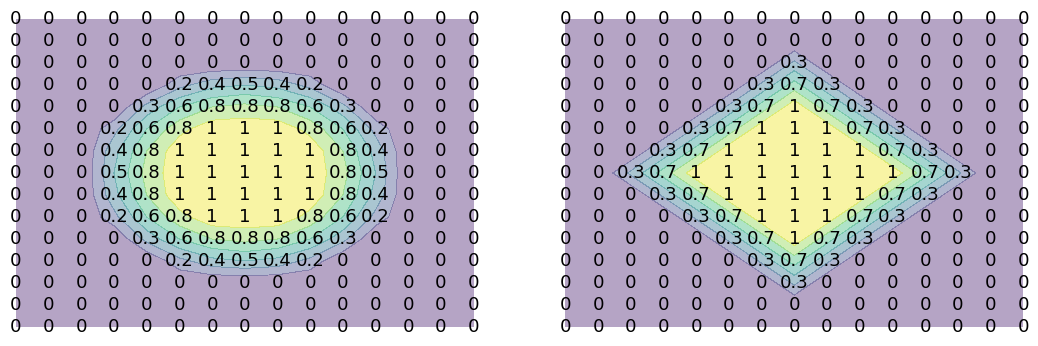

In [33]:
x,y = np.meshgrid(np.arange(-7,7.1), np.arange(-7,7.1))

fig, (ax1, ax2) = plt.subplots(1,2,figsize = (13,4))

# ax1.contourf(x, y, circle, alpha=0.5)
# # ax1.scatter(x, y, circle)
# for i in range(len(x)):
#     for j in range(len(y)):
#         ax1.text(x[i][j], y[i][j], '%d'% circle[i][j], ha='center', va='center')

circle_fuzzy = np.minimum([1], np.maximum([0], 25-x**2-y**2)/20)

ax1.contourf(x, y, circle_fuzzy, alpha=0.4, vmin=0, vmax=1)
# ax1.scatter(x, y, circle_fuzzy)
for i in range(len(x)):
    for j in range(len(y)):
        fmt = '%d' if circle_fuzzy[i][j] %1 ==0 else '%1.1f'
        ax1.text(x[i][j], y[i][j], fmt % circle_fuzzy[i][j] , ha='center', va='center')

diamond = np.minimum([1], np.maximum([0], (3 - abs(x)) + (3 - abs(y)))/3)

ax2.contourf(x,y,diamond, alpha=0.4, vmin=0, vmax=1)
for i in range(len(x)):
    for j in range(len(y)):
        fmt = '%d' if diamond[i][j] %1 ==0 else '%1.1f'
        ax2.text(x[i][j], y[i][j], fmt % diamond[i][j] , ha='center', va='center')

for ax in (ax1, ax2): ax.set_axis_off()

Segmentation masks - for now only do object (circle, diamonds), will add background later on. Truth value mask is zero/one outside/inside of object. Predicted mask has continuous values.

In [34]:
def fuzzy_circle(xy=(0,0), r=4, fuzz_factor=0.8):
    x0, y0 = xy
    max_fuzz = fuzz_factor * r**2
    circle = np.minimum([1], np.maximum([0], r**2 - (x-x0)**2 - (y-y0)**2)/max_fuzz)
    return circle

def fuzzy_diamond(xy=(0,0), r=2, fuzz_factor=1.5):
    x0, y0 = xy
    max_fuzz = fuzz_factor * r
    diamond = np.minimum([1], np.maximum([0], (r - abs(x-x0)) + (r-abs(y-y0)))/max_fuzz)
    return diamond

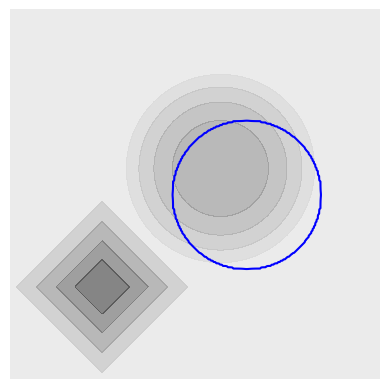

In [35]:
fine_grid = np.meshgrid(np.arange(-7,7.1,0.05), np.arange(-7,7.1,0.05))
x,y = fine_grid

zz = fuzzy_circle((2,0), r=3, fuzz_factor=0.1)
plt.contour(x, y, zz, levels = [0.99], colors='b')
zz = fuzzy_circle((1,1))
plt.contourf(x, y, zz, alpha=0.5, levels=[0,0.25,0.5,0.75,0.99,1.25], cmap = 'gray_r')
zz = fuzzy_diamond(xy=(-3.5,-3.5))
plt.contourf(x, y, zz, alpha=0.5, levels=[0,0.25,0.5,0.75,0.99,1.25], cmap = 'gray_r')
plt.gca().set_aspect(1)
plt.gca().set_axis_off()

Compute IoU and Dice metrics for series of two overlapping circles

           explicit   np function
IoU        1.00       1.00      
Dice       1.00       1.00      
IoU        0.52       0.52      
Dice       0.69       0.69      
IoU        0.25       0.25      
Dice       0.40       0.40      


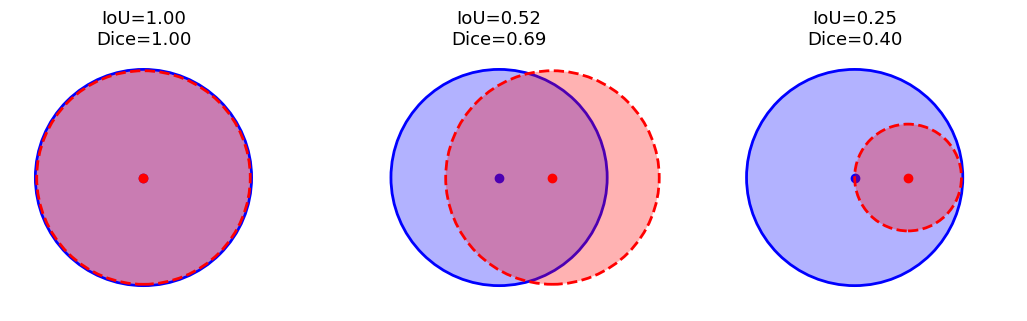

In [36]:
fig, axes = plt.subplots(1,3, figsize = (13,4))
params = [((0,0), 4), ((2,0), 4, ), ((2,0), 2) ]
y_true = fuzzy_circle(fuzz_factor=0.01)

print('{:<10s} {:<10s} {:<10s}'.format('','explicit', 'np function'))

for i in range(len(axes)):
    axes[i].scatter(0,0, c='b')
    axes[i].add_artist(plt.Circle((0, 0), 4.05, lw=2, edgecolor='b', facecolor=(0,0,1,0.3), zorder=1))
    xy, r = params[i]
    axes[i].scatter(*xy, c='r')
    axes[i].add_artist(plt.Circle(xy, r, lw=2, ls='--', edgecolor='r', facecolor=(1,0,0,0.3), zorder=1))
    
    smooth = 0.001
    y_pred = fuzzy_circle(xy, r, 0.01)
    intersection = np.sum(np.logical_and(y_true, y_pred))
    union = np.sum(np.logical_or(y_pred, y_true))
    iou = np.mean((intersection)/union)
    dice = 2*np.mean(intersection/(np.sum(y_pred)+np.sum(y_true)))
    
    print('{:<10s} {:<10.2f} {:<10.2f}'.format('IoU', iou, metrics_np(np.reshape(y_true, (1,)+y_true.shape+(1,)), np.reshape(y_pred, (1,)+y_pred.shape+(1,)), metric_name = 'iou')))
    print('{:<10s} {:<10.2f} {:<10.2f}'.format('Dice', dice, metrics_np(np.reshape(y_true, (1,)+y_true.shape+(1,)), np.reshape(y_pred, (1,)+y_pred.shape+(1,)), metric_name = 'dice')))
    
    axes[i].text(0,5, f'IoU={iou:1.2f}\nDice={dice:1.2f}', ha='center')
    
    axes[i].set_axis_off()
    axes[i].set(aspect=1, xlim=(-5,6.1), ylim=(-5,6))
fig.savefig('metrics_iou_dice.png',bbox_inches='tight')

In [48]:
y_true = fuzzy_circle(fuzz_factor=0.01)
y_pred = fuzzy_circle(xy, r, 0.01)
print(y_true)
print(y_pred)
print(y_true.shape)
print(y_pred.shape)
print('{:<10s} {:<10.2f} {:<10.2f}'.format('IoU', iou, metrics_np(np.reshape(y_true, (1,)+y_true.shape+(1,)), np.reshape(y_pred, (1,)+y_pred.shape+(1,)), metric_name = 'iou')))
print('{:<10s} {:<10.2f} {:<10.2f}'.format('Dice', dice, metrics_np(np.reshape(y_true, (1,)+y_true.shape+(1,)), np.reshape(y_pred, (1,)+y_pred.shape+(1,)), metric_name = 'dice')))
    

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

           explicit   np function
IoU        1.00       1.00      
soft IoU   0.60       0.60      
IoU        1.00       1.00      
soft IoU   0.50       0.50      
IoU        0.52       0.52      
soft IoU   0.42       0.42      
IoU        0.25       0.25      
soft IoU   0.15       0.15      


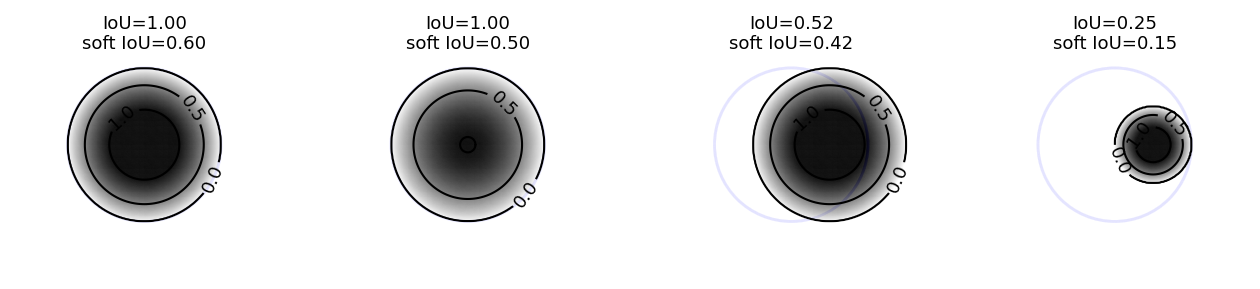

In [37]:
x,y = fine_grid
fig, axes = plt.subplots(1,4, figsize = (16,4))
params = [((0,0), 4, 0.8), ((0,0), 4, 1), ((2,0), 4, 0.8), ((2,0), 2, 0.8) ]
y_true = fuzzy_circle(fuzz_factor=0.01)

print('{:<10s} {:<10s} {:<10s}'.format('','explicit', 'np function'))

for i in range(len(axes)):
    # axes[i].contour(x, y, y_true, levels = [0.99], colors='b')
    axes[i].add_artist(plt.Circle((0, 0), 4, lw=2, edgecolor='b', facecolor=(0,0,0,0), zorder=1))
    xy, r, fuzz_factor = params[i]
    y_pred = fuzzy_circle(xy, r, fuzz_factor)
    # axes[i].contourf(x, y, y_pred, alpha=0.5, levels=[0.01,0.5,0.99,1.25], cmap = 'gray_r')
    axes[i].pcolormesh(x, y, y_pred, alpha=0.3, shading='gouraud', cmap = 'gray_r')
    cs = axes[i].contour(x, y, y_pred, levels=[0.01,0.5,0.99,1.25], colors = 'k')
    axes[i].clabel(cs, fmt='%1.1f')
    
    intersection = np.sum(np.logical_and(y_true, y_pred))
    union = np.sum(np.logical_or(y_pred, y_true))
    iou = np.mean(intersection/union)
    
    intersection_soft = np.sum(np.abs(y_true * y_pred))
    union_soft = np.sum(np.abs(y_pred)) + np.sum(np.abs(y_true)) - intersection_soft
    iou_soft = np.mean(intersection_soft/union_soft)

    print('{:<10s} {:<10.2f} {:<10.2f}'.format('IoU',iou, metrics_np(np.reshape(y_true, (1,)+y_true.shape+(1,)), np.reshape(y_pred, (1,)+y_pred.shape+(1,)), metric_name='iou')))
    print('{:<10s} {:<10.2f} {:<10.2f}'.format('soft IoU',iou_soft, metrics_np(np.reshape(y_true, (1,)+y_true.shape+(1,)), np.reshape(y_pred, (1,)+y_pred.shape+(1,)),metric_name='iou', metric_type='soft')))
    
    axes[i].text(0,5, f'IoU={iou:1.2f}\nsoft IoU={iou_soft:1.2f}', ha='center')
    
    axes[i].set_axis_off()
    axes[i].set(aspect=1)
fig.savefig('metrics_iou_dice_soft.png',bbox_inches='tight')

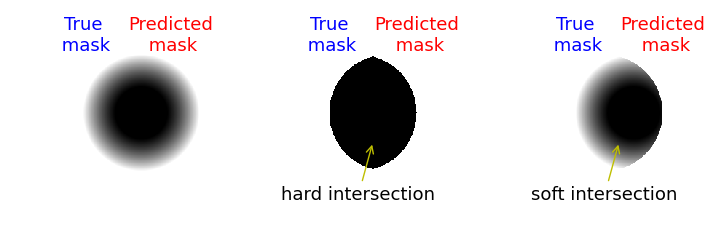

In [38]:
y_true = fuzzy_circle(fuzz_factor=0.01)
y_pred = fuzzy_circle((2,0), 4, 0.8)

fig, axes = plt.subplots(1,3, figsize=(9,3))
for ax in axes:
    ax.set_axis_off(); ax.set(aspect=1)
    ax.add_artist(plt.Circle((0, 0), 4, lw=2, edgecolor='b', facecolor=(0,0,0,0), zorder=1))
    ax.text(-2,4,'True\n mask', ha='center', va='bottom', color='b')
    ax.add_artist(plt.Circle((2, 0), 4, lw=2, edgecolor='r', facecolor=(0,0,0,0), zorder=1))
    ax.text(4,4,'Predicted\n mask', ha='center', va='bottom', color='r')
    iax=list(axes).index(ax)
    if iax>0:
        axes[iax].annotate(['hard ','soft '][iax-1]+'intersection', (1,-2), xytext=(0,-6), ha='center', arrowprops={'arrowstyle': '->', 'color':'y'}, zorder=2)
        
axes[0].pcolormesh(x,y, y_pred, cmap='gray_r')
axes[1].pcolormesh(x,y, np.logical_and(y_true, y_pred), cmap='gray_r')
axes[2].pcolormesh(x,y, y_true * y_pred, cmap='gray_r');
fig.savefig('metrics_intersection_soft.png',bbox_inches='tight')

To test the non-naive mean_IoU, I need multiple classes, the masks of which overlap for only a small subset. I will arbitrarily take a circle and a diamond as examples of two classes, offset them a little and then find the IoU's

IoU of first class:                                          0.726
IoU of second class:                                         0.286
IoU of background:                                           0.775
IoU of each class (explicit list):                           [0.72645972 0.28643223 1.         1.         0.7748001 ]
mean IoU of all classes (no background, naive mean):         0.753
mean IoU of all classes (with background, naive mean):       0.758
mean IoU of all non-absent classes (dropping background):    0.506


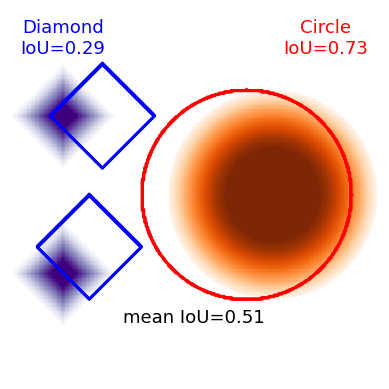

In [39]:
x,y = fine_grid
true1 = fuzzy_circle(xy=(2,0), fuzz_factor=0.01)
pred1 = fuzzy_circle(xy=(3,0))
# two instances of Diamond class: first has IoU=0.33 (half overlap), second one has IoU=0.24
true2 = fuzzy_diamond(xy=(-4,-2),r=1,fuzz_factor=0.01)  + fuzzy_diamond(xy=(-3.5,3),r=1,fuzz_factor=0.01)
pred2 = fuzzy_diamond(xy=(-5,-3),r=1) + fuzzy_diamond(xy=(-5,3),r=1)
empty = np.zeros_like(true1)

plt.contour(x,y,true1, colors='r')
plt.contour(x,y,true2, colors='b')

plt.pcolormesh(x,y,pred1, cmap=mpl.colors.ListedColormap([(0,0,0,0)]+list(map(plt.get_cmap('Oranges'), range(256)))[1:]))
plt.pcolormesh(x,y,pred2, cmap=mpl.colors.ListedColormap([(0,0,0,0)]+list(map(plt.get_cmap('Purples'), range(256)))[1:]))
plt.gca().set_axis_off()
plt.gca().set(aspect=1)

y_true = np.expand_dims(np.stack([true1, true2, empty, empty, (true1==0) & (true2==0).astype(int)], axis=-1), axis=0)
y_pred = np.expand_dims(np.stack([pred1, pred2, empty, empty, (pred1==0) & (pred2==0).astype(int)], axis=-1), axis=0)

print('{:<60s} {:.3f}'.format('IoU of first class:', metrics_np(y_true[:,:,:,:1], y_pred[:,:,:,:1], metric_name='iou')))
print('{:<60s} {:.3f}'.format('IoU of second class:', metrics_np(y_true[:,:,:,1:2], y_pred[:,:,:,1:2], metric_name='iou')))
print('{:<60s} {:.3f}'.format('IoU of background:', metrics_np(y_true[:,:,:,-1:], y_pred[:,:,:,-1:], metric_name='iou')))
print('{:<60s} {}'.format('IoU of each class (explicit list):', metrics_np(y_true, y_pred, metric_name='iou', metric_type='naive', drop_last=False, mean_per_class=True)))
print('{:<60s} {:.3f}'.format('mean IoU of all classes (no background, naive mean):', metrics_np(y_true, y_pred, metric_name='iou', metric_type='naive')))
print('{:<60s} {:.3f}'.format('mean IoU of all classes (with background, naive mean):', metrics_np(y_true, y_pred, metric_name='iou', metric_type='naive', drop_last = False)))
print('{:<60s} {:.3f}'.format('mean IoU of all non-absent classes (dropping background):', metrics_np(y_true, y_pred, metric_name='iou')))

plt.text(5,6,'Circle\nIoU={:1.2f}'.format(metrics_np(y_true[:,:,:,:1], y_pred[:,:,:,:1], metric_name='iou')), color='r', ha='center', va='center')
plt.text(-5,6,'Diamond\nIoU={:1.2f}'.format(metrics_np(y_true[:,:,:,1:2], y_pred[:,:,:,1:2], metric_name='iou')), color='b', ha='center', va='center')
plt.text(0,-5,'mean IoU={:1.2f}'.format(metrics_np(y_true, y_pred, metric_name='iou')), ha='center', va='bottom');

plt.savefig('metrics_mean_iou_multiclass.png', bbox_inches='tight')

So far I have used batch_size=1. Test the difference between naive and standard ways to take the mean, for multiple examples. Here I will take two images, the first with two classes as above and the second one with only the circle.

In [40]:
y_true = np.stack([np.stack([true1, true2, empty, empty, (true1==0) & (true2==0).astype(int)], axis=-1),
                   np.stack([true1, empty, empty, empty, (true1==0)], axis=-1)])
y_pred = np.stack([np.stack([pred1, pred2, empty, empty, (pred1==0) & (pred2==0).astype(int)], axis=-1),
                   np.stack([pred1, empty, empty, empty, (pred1==0)], axis=-1)])

print('Naive per-class mean:    {}  --  Overall mean: {:1.2f}'.format(
    metrics_np(y_true, y_pred, metric_name='iou', metric_type='naive', mean_per_class=True), 
    metrics_np(y_true, y_pred, metric_name='iou', metric_type='naive')))
print('Standard per-class mean: {}  --  Overall mean: {:1.2f}'.format(
    metrics_np(y_true, y_pred, metric_name='iou', mean_per_class=True), 
    metrics_np(y_true, y_pred, metric_name='iou')))
print('Standard per-class mean, with background', metrics_np(y_true, y_pred, metric_name='iou', mean_per_class=True, drop_last=False))
# metrics_np(y_true, y_pred, metric_name='iou', mean_per_class=True),\
# metrics_np(y_true, y_pred, metric_name='iou'),\
print('Soft per-class mean    ', metrics_np(y_true, y_pred, metric_name='iou', metric_type='soft', mean_per_class=True))

Naive per-class mean:    [0.72645972 0.64321612 1.         1.        ]  --  Overall mean: 0.84
Standard per-class mean: [0.72659643 0.28714509 1.         1.        ]  --  Overall mean: 0.51
Standard per-class mean, with background [0.72659643 0.28714509 1.         1.         0.83668973]
Soft per-class mean     [0.54782264 0.17182951 1.         1.        ]


Test Keras version and verify it gives same result as Numpy

In [41]:
print('hard IoU   {:1.6f} {:1.6f}'.format(metrics_np(y_true, y_pred, metric_name='iou'), 
                                        K.eval(seg_metrics(y_true, y_pred, metric_name='iou'))))
print('soft IoU   {:1.6f} {:1.6f}'.format(metrics_np(y_true, y_pred, metric_name='iou', metric_type='soft'), 
                                        K.eval(seg_metrics(y_true, y_pred, metric_name='iou', metric_type='soft'))))
print('hard IoU, naive mean {:1.6f} {:1.6f}'.format(metrics_np(y_true, y_pred, metric_name='iou', metric_type='naive'), 
                                                  K.eval(seg_metrics(y_true, y_pred, metric_name='iou', metric_type='naive'))))
print('hard Dice   {:1.6f} {:1.6f}'.format(metrics_np(y_true, y_pred, metric_name='dice'), 
                                        K.eval(seg_metrics(y_true, y_pred, metric_name='dice'))))

hard IoU   0.506446 0.506446
soft IoU   0.359299 0.359298
hard IoU, naive mean 0.842419 0.842419
hard Dice   0.643436 0.643436


Print verbose info for metrics: look at number of pixels in intersection, union for each class and each input (batch * classes axes)

In [42]:
metrics_np(y_true, y_pred, metric_name='iou', verbose=True),\
metrics_np(y_true, y_pred, metric_name='iou', metric_type='standard', mean_per_class=True),\
K.eval(seg_metrics(y_true, y_pred, metric_name='iou', verbose=True))

intersection (pred*true), intersection (pred&true), union (pred+true-inters), union (pred|true)
[[16896  2850     0     0 46316]
 [16896     0     0     0 56266]] [[16896  2850     0     0 46316]
 [16896     0     0     0 56266]] [[23258  9950     0     0 59778]
 [23258     0     0     0 62628]] [[23258  9950     0     0 59778]
 [23258     0     0     0 62628]]
intersection, union
[[16896.  2850.     0.     0. 46316.]
 [16896.     0.     0.     0. 56266.]] [[23258.  9950.     0.     0. 59778.]
 [23258.     0.     0.     0. 62628.]]
[[0.72645974 0.28643215        nan        nan 0.7748001 ]
 [0.72645974        nan        nan        nan 0.89841604]]
Counts of inputs with class present, metrics for non-absent classes
[2. 1. 0. 0.] [0.72645974 0.28643224]


(0.506445978533749,
 array([0.72659643, 0.28714509, 1.        , 1.        ]),
 0.506446)

## Coarse-grained example
Image with few pixels to explicitly check what is going on at the pixel level

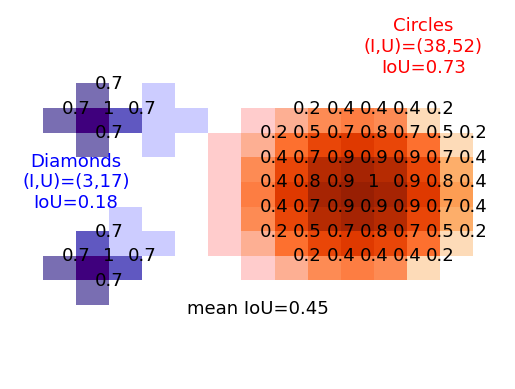

In [43]:
x,y = np.meshgrid(np.arange(-7,7.1,1), np.arange(-7,7.1,1))

true1 = fuzzy_circle(xy=(2,0), fuzz_factor=0.01)
pred1 = fuzzy_circle(xy=(3,0), fuzz_factor=1)
# two instances of Diamond class: first has IoU=0.33 (half overlap), second one has IoU=0.24
true2 = fuzzy_diamond(xy=(-4,-2),r=1,fuzz_factor=0.01)  + fuzzy_diamond(xy=(-3,3),r=1,fuzz_factor=0.01)
pred2 = fuzzy_diamond(xy=(-5,-3),r=1) + fuzzy_diamond(xy=(-5,3),r=1)
empty = np.zeros_like(true1)

# build N*W*H*C ground truth and predicted masks
y_true = np.stack([np.stack([true1, true2, empty, empty, (true1==0) & (true2==0).astype(int)], axis=-1),
                   np.stack([true1, empty, empty, empty, (true1==0)], axis=-1)])
y_pred = np.stack([np.stack([pred1, pred2, empty, empty, (pred1==0) & (pred2==0).astype(int)], axis=-1),
                   np.stack([pred1, empty, empty, empty, (pred1==0)], axis=-1)])

# plot predicted masks
plt.pcolormesh(x,y,pred1, cmap=mpl.colors.ListedColormap([(0,0,0,0)]+list(map(plt.get_cmap('Oranges'), range(256)))[1:]))
plt.pcolormesh(x,y,pred2, cmap=mpl.colors.ListedColormap([(0,0,0,0)]+list(map(plt.get_cmap('Purples'), range(256)))[1:]))

# plot true masks
plt.pcolormesh(x,y,true1, cmap=mpl.colors.ListedColormap([(0,0,0,0), (1,0,0,0.2)]))
plt.pcolormesh(x,y,true2, cmap=mpl.colors.ListedColormap([(0,0,0,0), (0,0,1,0.2)]))

for i in range(len(x)):
    for j in range(len(y)):
        if pred1[i][j]!=0:
            fmt = '%d' if pred1[i][j] %1 ==0 else '%1.1f'
            plt.text(x[i][j]+0.5, y[i][j]+0.5, fmt % pred1[i][j] , ha='center', va='center')
        if pred2[i][j]!=0:
            fmt = '%d' if pred2[i][j] %1 ==0 else '%1.1f'
            plt.text(x[i][j]+0.5, y[i][j]+0.5, fmt % pred2[i][j] , ha='center', va='center')

plt.text(5,6,'Circles\n(I,U)=({:},{:})\nIoU={:1.2f}'.format(np.logical_and(pred1, true1).sum(), np.logical_or(pred1, true1).sum(),
            metrics_np(y_true[:1,:,:,:1], y_pred[:1,:,:,:1], metric_name='iou')), color='r', ha='center', va='center')
plt.text(-5.5,0.5,'Diamonds\n(I,U)=({:},{:})\nIoU={:1.2f}'.format(np.logical_and(pred2, true2).sum(), np.logical_or(pred2, true2).sum(),
            metrics_np(y_true[:1,:,:,1:2], y_pred[:1,:,:,1:2], metric_name='iou')), color='b', ha='center', va='center')
plt.text(0,-5,'mean IoU={:1.2f}'.format(metrics_np(y_true[:1], y_pred[:1], metric_name='iou')), ha='center', va='bottom');

plt.gca().set_axis_off()
# plt.gca().set(aspect=1)
plt.savefig('metrics_mean_iou_coarse_example.png', bbox_inches='tight')

In [44]:
metrics_np(y_true, y_pred, metric_name='iou',verbose=True),\
metrics_np(y_true, y_pred, metric_name='iou', mean_per_class=True),\
K.eval(seg_metrics(y_true, y_pred, metric_name='iou', verbose=True))

intersection (pred*true), intersection (pred&true), union (pred+true-inters), union (pred|true)
[[ 38   3   0   0 156]
 [ 38   0   0   0 173]] [[ 38   3   0   0 156]
 [ 38   0   0   0 173]] [[ 52  17   0   0 184]
 [ 52   0   0   0 187]] [[ 52  17   0   0 184]
 [ 52   0   0   0 187]]
intersection, union
[[ 38.   3.   0.   0. 156.]
 [ 38.   0.   0.   0. 173.]] [[ 52.  17.   0.   0. 184.]
 [ 52.   0.   0.   0. 187.]]
[[0.7307692  0.1764706         nan        nan 0.84782606]
 [0.7307692         nan        nan        nan 0.9251337 ]]
Counts of inputs with class present, metrics for non-absent classes
[2. 1. 0. 0.] [0.7307744  0.17651904]


(0.45364671823845565,
 array([0.73090895, 0.17734169, 1.        , 1.        ]),
 0.45364672)